In [33]:
from utide import solve, reconstruct
import utide
from xmitgcm import open_mdsdataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from os.path import expanduser,join,isdir
import sys
user_home_dir = expanduser('~')
ecco_v4_py_dir = join(user_home_dir,'ECCOv4-py')
if isdir(ecco_v4_py_dir):
    sys.path.insert(0,ecco_v4_py_dir)
from ecco_v4_py import plot_proj_to_latlon_grid
import ecco_v4_py as ecco
import pandas as pd

In [8]:
data_dir ='/efs_ecco/hvanderz/export_tides'
grid_dir ='/efs_ecco/hvanderz/r5/WORKINGDIR/ECCOV4/release5_ToTs/run'
#ds = open_mdsdataset(data_dir, grid_dir=grid_dir, prefix={'ETAN'}) #native grid
ds_llc = open_mdsdataset(data_dir, 
                        grid_dir=grid_dir, 
                         prefix={'ETAN'},
                         geometry="llc") #non-native grid

# display the contents of the Dataset
ds_llc = ds_llc.rename({'face':'tile'})

In [9]:
ds_llc

<xarray.Dataset> Size: 5GB
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50,
                k_p1: 51, tile: 13, time: 10922)
Coordinates: (12/48)
  * i          (i) int64 720B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int64 720B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int64 720B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int64 720B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * k          (k) int64 400B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_u        (k_u) int64 400B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
    ...         ...
    dxF        (tile, j, i) >f4 421kB dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    dxV        (tile, j_g, i_g) >f4 421kB dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    rhoRef     (k) >f4 200B dask.array<chunksize=(50,), meta=np.ndarray>
    dyF        (tile, j, i) >f4 421kB dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    iter       (time) int64 87kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time       (time) timedelta64[ns] 87kB 00:00:02 00:00:04 ... 06:04:04
Data variables:
    ETAN       (time, tile, j, i) float32 5GB dask.array<chunksize=(1, 1, 90, 90), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(data_dir='/efs_ecco/hva...

In [93]:
ecco.get_section_endpoints('englishchannel')


([-4.5, 48], [-5, 50.5])

/srv/conda/envs/notebook/lib/python3.12/site-packages/matplotlib/colors.py:744: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
/srv/conda/envs/notebook/lib/python3.12/site-packages/matplotlib/colors.py:744: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
/srv/conda/envs/notebook/lib/python3.12/site-packages/matplotlib/colors.py:744: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


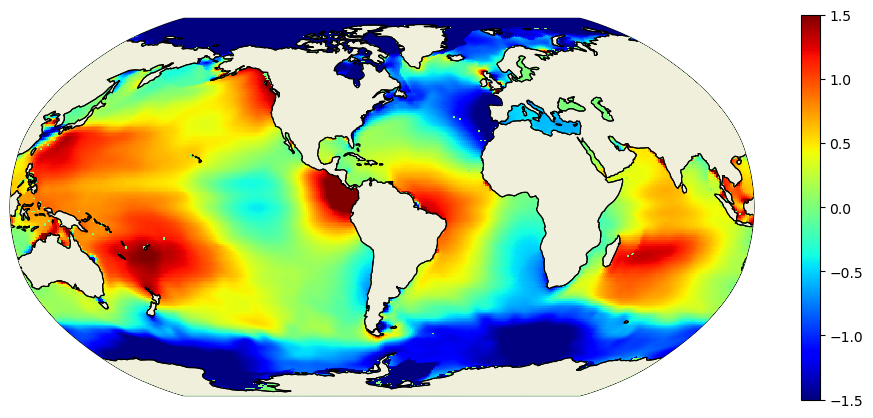

In [94]:
plt.figure(figsize=[12,5]);
jet_colMap_k = cm.jet
jet_colMap_k.set_bad(color='black')

jet_colMap_w = cm.jet
jet_colMap_w.set_bad(color='white')

X = plot_proj_to_latlon_grid(ds_llc.XC, ds_llc.YC,ds_llc.ETAN.isel(time=10100), 
                                 cmap=jet_colMap_w, cmin= -1.5, cmax = 1.5,
                                  show_colorbar=True, user_lon_0=-66)

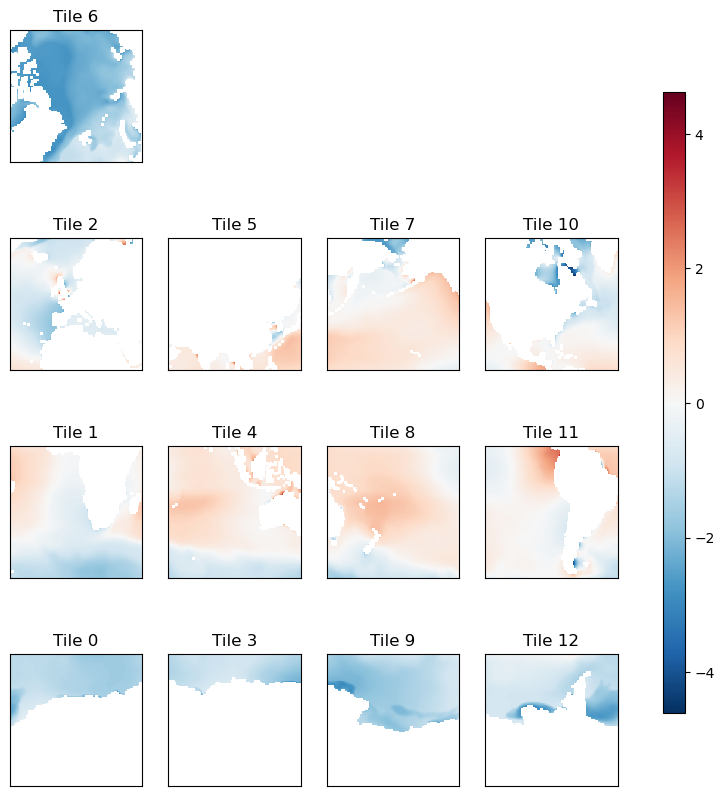

In [98]:
ecco.plot_tiles(ds_llc.ETAN.isel(time=10100).where(ds_llc.maskC[0]), show_colorbar=True, show_tile_labels=True,
                layout='latlon', rotate_to_latlon=True);

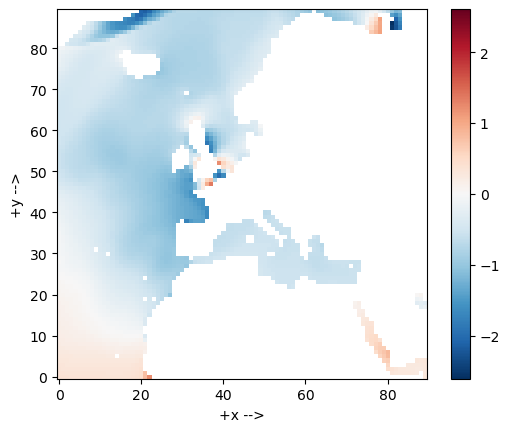

In [54]:
dates = pd.date_range('1992-01-01','1993-04-01',freq='1h') # range of dates in days
# Get the latitude at this point
latp = ds_llc['YC'].isel(tile=4, j=45, i=45).values # Converts tile coordinate in latitude
#print(np.shape(ds_llc.time.values))
print(np.shape(dates[:-23]), np.shape(ds_llc.isel(tile=4, i=45,j=45).ETAN.values))

(10922,) (10922,)


(np.float64(8035.041666666667), np.float64(8076.666666666667))

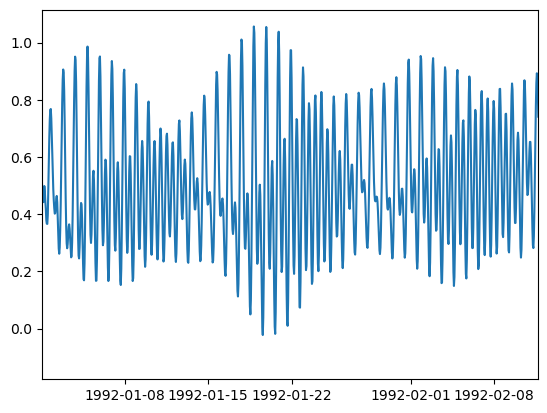

In [60]:
plt.plot(dates[:-23], ds_llc.ETAN.isel(tile = 4, i=45, j=45).values)
plt.xlim(dates[1],dates[1000])

In [82]:
coef = solve(
    t = dates[:-23], #idk why dates has 1 more element than ETAN, so I remove the last one.
    #t  =
    #t= time_test,
    u = ds_llc.isel(tile=4, i=45,j=45).ETAN.values,
    lat=latp,
    nodal=False,
    trend=False,
    method="ols",
    conf_int="none",
    #Rayleigh_min=0.8,
    #constit=['M2', 'S2', 'K1', 'O1'], #we can chose the components we fit.
    #epoch ='1992-01-01'
)

solve: matrix prep ... solution ... done.


In [61]:
tide  = reconstruct( dates[:-23], coef,verbose = True)

prep/calcs ... done.


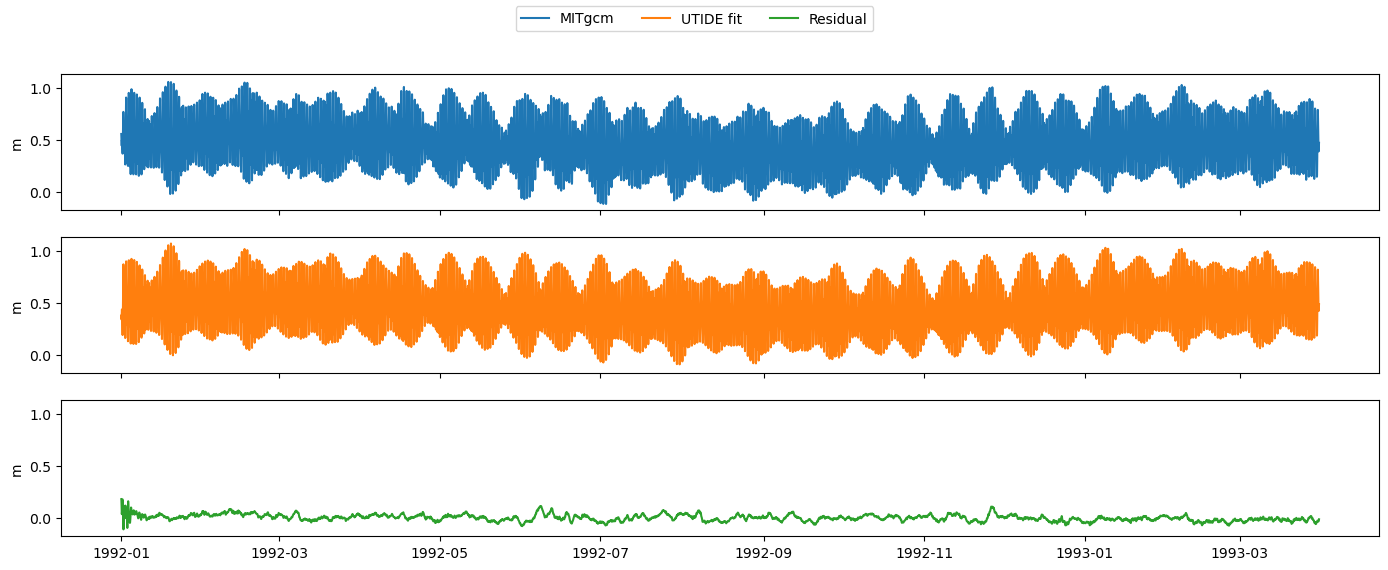

In [63]:
#t = coef.index.to_pydatetime()

fig, (ax0, ax1, ax2) = plt.subplots(figsize=(17, 6), nrows=3, sharey=True, sharex=True)

ax0.plot( dates[:-23],  ds_llc.isel(tile=4, i=45,j=45).ETAN.values, label="MITgcm", color="C0")
ax1.plot( dates[:-23], tide.h, label="UTIDE fit", color="C1")
ax2.plot(  dates[:-23],  ds_llc.isel(tile=4, i=45,j=45).ETAN.values - tide.h, label="Residual", color="C2")
ax0.set_ylabel('m')
ax1.set_ylabel('m')
ax2.set_ylabel('m')
#ax0.plot(ds_llc.time.values,  ds_llc.isel(tile=4, i=45,j=45).ETAN.values, label="Observations", color="C0")
#ax1.plot(ds_llc.time.values, tide.h, label="Prediction", color="C1")
#ax2.plot(ds_llc.time.values,  ds_llc.isel(tile=4, i=45,j=45).ETAN.values - tide.h, label="Residual", color="C2")
fig.legend(ncol=3, loc="upper center");
plt.savefig('../Plots/utide_1y3m.pdf',bbox_inches='tight')

In [88]:
sumamp = 0
for name, amp, gphase in zip(coef.name, coef.A, coef.g):
    if amp>0.0009:
        print(f"{name}:  complex amplitude = {amp:.3f}, Greenwich phase = {gphase:.3f}")
        sumamp+=amp
print(sumamp)

M2:  complex amplitude = 0.227, Greenwich phase = 253.633
O1:  complex amplitude = 0.127, Greenwich phase = 337.283
K1:  complex amplitude = 0.106, Greenwich phase = 323.251
S2:  complex amplitude = 0.080, Greenwich phase = 287.785
SA:  complex amplitude = 0.071, Greenwich phase = 61.640
N2:  complex amplitude = 0.042, Greenwich phase = 242.253
P1:  complex amplitude = 0.035, Greenwich phase = 331.277
Q1:  complex amplitude = 0.023, Greenwich phase = 322.762
K2:  complex amplitude = 0.022, Greenwich phase = 261.410
NO1:  complex amplitude = 0.009, Greenwich phase = 314.832
SSA:  complex amplitude = 0.009, Greenwich phase = 267.104
NU2:  complex amplitude = 0.008, Greenwich phase = 244.094
S1:  complex amplitude = 0.008, Greenwich phase = 296.051
MF:  complex amplitude = 0.007, Greenwich phase = 348.943
J1:  complex amplitude = 0.006, Greenwich phase = 310.161
MU2:  complex amplitude = 0.006, Greenwich phase = 235.406
MSF:  complex amplitude = 0.006, Greenwich phase = 238.354
2N2:  comp

In [83]:
print(coef.keys())

dict_keys(['name', 'aux', 'nR', 'nNR', 'nI', 'weights', 'A', 'g', 'mean', 'PE'])


# OTHER POINTS

In [100]:
ecco.get_section_endpoints('englishchannel')


([-4.5, 48], [-5, 50.5])

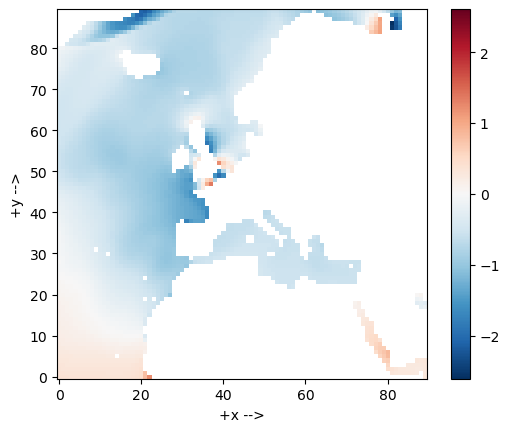

In [101]:
ecco.plot_tile(ds_llc.ETAN.isel(time=300, tile=2).where(ds_llc.maskC[0].isel(tile=2)), show_colorbar=True);
